In [20]:
import os
import fitsio
import pandas as pd
import numpy as np
import cudf
from numba import cuda
import cupy as cp
from pathlib import Path, PurePath
import matplotlib.pyplot as plt
import sunpy.visualization.colormaps
import matplotlib.colors as colors
FS = 16

In [2]:
def get_dist_mat(coords):
    coords_x = coords % 4096
    coords_y = coords // 4096
    coords_xb = coords_x[:, np.newaxis]
    coords_yb = coords_y[:, np.newaxis]
    dx_broadc = coords_x - coords_xb
    dy_broadc = coords_y - coords_yb
    dist_matrix = dx_broadc**2 + dy_broadc**2
    return dist_matrix

def get_dist_mat_gpu(coords):
    coords_x = coords % 4096
    coords_y = coords // 4096
    coords_xb = coords_x[:, cp.newaxis]
    coords_yb = coords_y[:, cp.newaxis]
#     dx_broadc = coords_x - coords_xb
#     dy_broadc = coords_y - coords_yb
#     dist_matrix = (coords_x - coords_xb)**2 + (coords_y - coords_yb)**2
    return (coords_x - coords_xb)**2 + (coords_y - coords_yb)**2

def get_rows_list(array, w1_idx, w2_idx):
    np_mask = (array[:, w1_idx] == 1) & (array[:, w2_idx] == 1)
    df_idx = np.nonzero(np_mask)[0]
    coords = array[np_mask, 0]
    dist_matrix = get_dist_mat(coords)
    select = dist_matrix < 2 
    select2 = np.triu(select, k=1)
    r,c = np.nonzero(select2)
    idx1, idx2 = df_idx[r], df_idx[c]
    return idx1, idx2

def get_rows_list_gpu(array, w1_idx, w2_idx):
    mask = (array[:, w1_idx] == 1) & (array[:, w2_idx] == 1)
    df_idx = cp.nonzero(mask)[0]
    coords = array[df_idx, 0]
    dist_matrix = get_dist_mat_gpu(coords)
    select = dist_matrix < 2 
    select2 = cp.triu(select, k=1)
    r,c = cp.nonzero(select2)
    idx1, idx2 = df_idx[r], df_idx[c]
    return idx1, idx2


def get_2coincidentals(array, w1_idx, w2_idx):
    idx1, idx2 = get_rows_list(array, w1_idx, w2_idx)
    records = [df0.loc[[i1, i2]][['coords', 'int1', 'int2', 'wref']] for i1, i2 in zip(idx1, idx2)]
    df_records = pd.concat(records, keys=list(range(len(records))))
    return df_records


def get_2clusters(array, w1_idx, w2_idx, group_n=None):
    idx1, idx2 = get_rows_list(array, w1_idx, w2_idx)
    # To remove conjugates
#     keep_mask = arr0[idx1, 3] != arr0[idx2, 3] 
#     recordsf = np.concatenate((arr0[idx1[keep_mask], 0:4], arr0[idx2[keep_mask], 0:4]), axis=1)
    
    records = np.concatenate((array[idx1, 0:4], array[idx2, 0:4]), axis=1)
    df_records = pd.DataFrame(records, columns=['coords1', 'int1_before', 'int1_after', 'wref1', 'coords2', 'int2_before', 'int2_after', 'wref2'])
    if group_n is not None:
        df_records['GroupNumber'] = group_n
    
    return df_records


def get_3clusters(array, w1_idx, w2_idx, w3_idx, group_n=None):
    df12 = get_2clusters(array, w1_idx, w2_idx, group_n=group_n)
    df13 = get_2clusters(array, w1_idx, w3_idx, group_n=group_n)
    series123 = df12['coords1'].loc[df12['coords1'].isin(df13['coords1'])]
    
    return series123


def get_2clusters_gpu(gpu_array, w1_idx, w2_idx):
    gidx1, gidx2 = get_rows_list_gpu(gpu_array, w1_idx, w2_idx)
    grecords = cp.concatenate([gpu_array[gidx1, 0:4], gpu_array[gidx2, 0:4]], axis=1)
    #grecords2 = cp.asfortranarray(grecords)
    #cudf_records = cudf.DataFrame.from_gpu_matrix(grecords2, columns=['coords1', 'int1_before', 'int1_after', 'wref1', 'coords2', 'int2_before', 'int2_after', 'wref2'])
    return records

In [3]:
data_dir = os.environ['SPIKESDATA']
spikes_db = pd.read_parquet(os.path.join(data_dir, 'spikes_df_2010.parquet'), columns=['GroupNumber', 'Time'], engine='pyarrow')
spikes_db.head()

,GroupNumber,Time
0,0,2010-05-13 00:00:02.090000+00:00
1,0,2010-05-13 00:00:03.570000+00:00
2,0,2010-05-13 00:00:05.070000+00:00
3,0,2010-05-13 00:00:06.580000+00:00
4,0,2010-05-13 00:00:08.080000+00:00


In [4]:
gdates = spikes_db.groupby('GroupNumber').nth(0)
print(len(gdates))
gdates.head()

1634668


,Time
GroupNumber,
0,2010-05-13 00:00:02.090000+00:00
1,2010-05-13 00:00:14.080000+00:00
2,2010-05-13 00:00:26.080000+00:00
3,2010-05-13 00:00:38.080000+00:00
4,2010-05-13 00:00:50.080000+00:00


### Load a parquet file (1 day of data)

In [5]:
parquet_dir = os.path.join(os.environ['SPIKESDF'], 'parquet_dataframes/')
df0 = pd.read_parquet(PurePath(parquet_dir, '2010/07/df_coincidentals_2010_07_12.parquet'), engine='pyarrow')

In [6]:
df0.head()

,coords,int1,int2,wref,w0,w1,w2,w3,w4,w5,w6,GroupNumber
0,63998,49,10,0,1,0,0,1,0,0,0,432000
1,86745,420,1,0,1,0,0,0,0,0,1,432000
2,97515,54,2,0,1,0,0,1,0,0,0,432000
3,101611,106,3,0,1,0,0,1,0,0,0,432000
4,126328,44,0,0,1,0,0,1,0,0,0,432000


In [7]:
df0.set_index('GroupNumber', inplace=True)
df0.head()

,coords,int1,int2,wref,w0,w1,w2,w3,w4,w5,w6
GroupNumber,,,,,,,,,,,
432000,63998,49,10,0,1,0,0,1,0,0,0
432000,86745,420,1,0,1,0,0,0,0,0,1
432000,97515,54,2,0,1,0,0,1,0,0,0
432000,101611,106,3,0,1,0,0,1,0,0,0
432000,126328,44,0,0,1,0,0,1,0,0,0


In [8]:
c = df0.groupby(level=0).size().rename('total count (>= 2-wave-overlap)')
c.head()

GroupNumber
432000    6007
432001    6395
432002    6100
432003    5919
432004    6422
Name: total count (>= 2-wave-overlap), dtype: int64

In [9]:
seriesccount = df0[['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6']].sum(axis=1).rename('overlaps')
seriesccount.head()

GroupNumber
432000    2
432000    2
432000    2
432000    2
432000    2
Name: overlaps, dtype: int64

In [10]:
df0['overlaps'] = seriesccount
df0.head()

,coords,int1,int2,wref,w0,w1,w2,w3,w4,w5,w6,overlaps
GroupNumber,,,,,,,,,,,,
432000,63998,49,10,0,1,0,0,1,0,0,0,2
432000,86745,420,1,0,1,0,0,0,0,0,1,2
432000,97515,54,2,0,1,0,0,1,0,0,0,2
432000,101611,106,3,0,1,0,0,1,0,0,0,2
432000,126328,44,0,0,1,0,0,1,0,0,0,2


In [11]:
c3 = df0.loc[df0['overlaps']==3].groupby(level=0).size().rename('3-wave-overlap count')

In [12]:
dfcount = pd.concat([gdates.loc[c.index], c, c3], axis=1)
dfcount.set_index('Time', inplace=True)
dfcount.head()

,total count (>= 2-wave-overlap),3-wave-overlap count
Time,,
2010-07-12 00:00:00.570000+00:00,6007,180.0
2010-07-12 00:00:12.550000+00:00,6395,200.0
2010-07-12 00:00:24.580000+00:00,6100,184.0
2010-07-12 00:00:36.550000+00:00,5919,165.0
2010-07-12 00:00:48.570000+00:00,6422,202.0


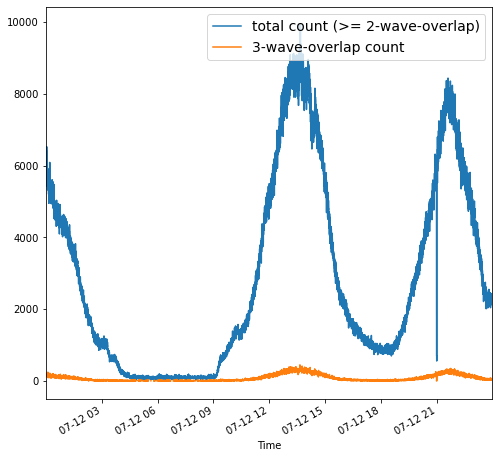

In [13]:
%matplotlib inline
dfcount.plot(figsize=(8,8))
plt.legend(fontsize=14)

In [14]:
print(len(df0.loc[seriesccount==5]))
df0.loc[seriesccount==3].head()

2135


,coords,int1,int2,wref,w0,w1,w2,w3,w4,w5,w6,overlaps
GroupNumber,,,,,,,,,,,,
432000,566052,346,8,0,1,0,1,0,0,1,0,3
432000,1593685,10,3,0,1,0,0,1,0,0,1,3
432000,2973759,180,3,0,1,0,0,1,1,0,0,3
432000,4931596,259,13,0,1,0,1,0,0,1,0,3
432000,6286935,634,186,0,1,0,0,1,0,0,1,3


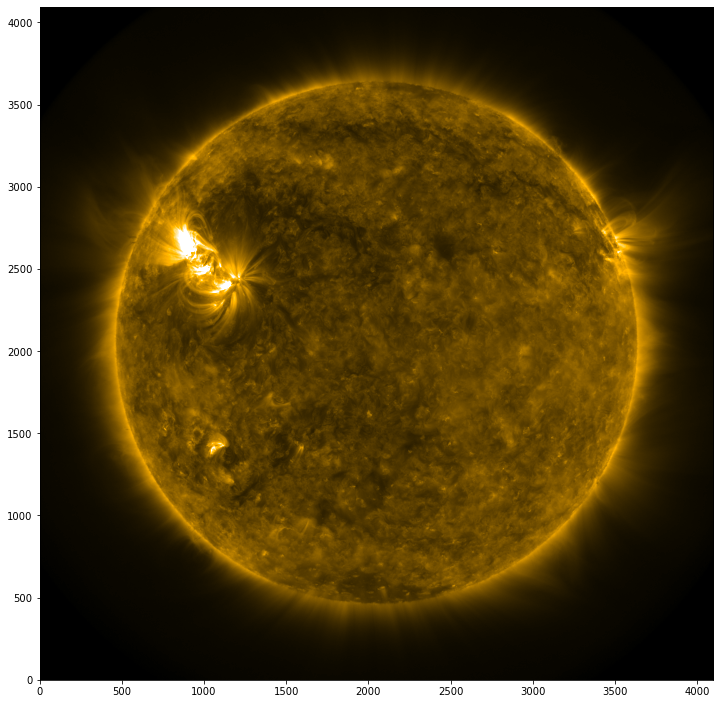

In [41]:
# Image constant and sample FITS image
r_sun = 1578
crpix = 2048.5
nx = 4096
ny = 4096

img = fitsio.read('FITS/aia.lev1.171A_2010-07-11T23_59_59.12Z.image_lev1.fits')
cmap = plt.get_cmap('sdoaia171')
plt.figure(figsize=(10,10))
plt.imshow(img, origin='lower', vmin=1, vmax=np.percentile(img, 99.9), 
           cmap=cmap, norm=colors.PowerNorm(gamma=0.6))
plt.tight_layout()

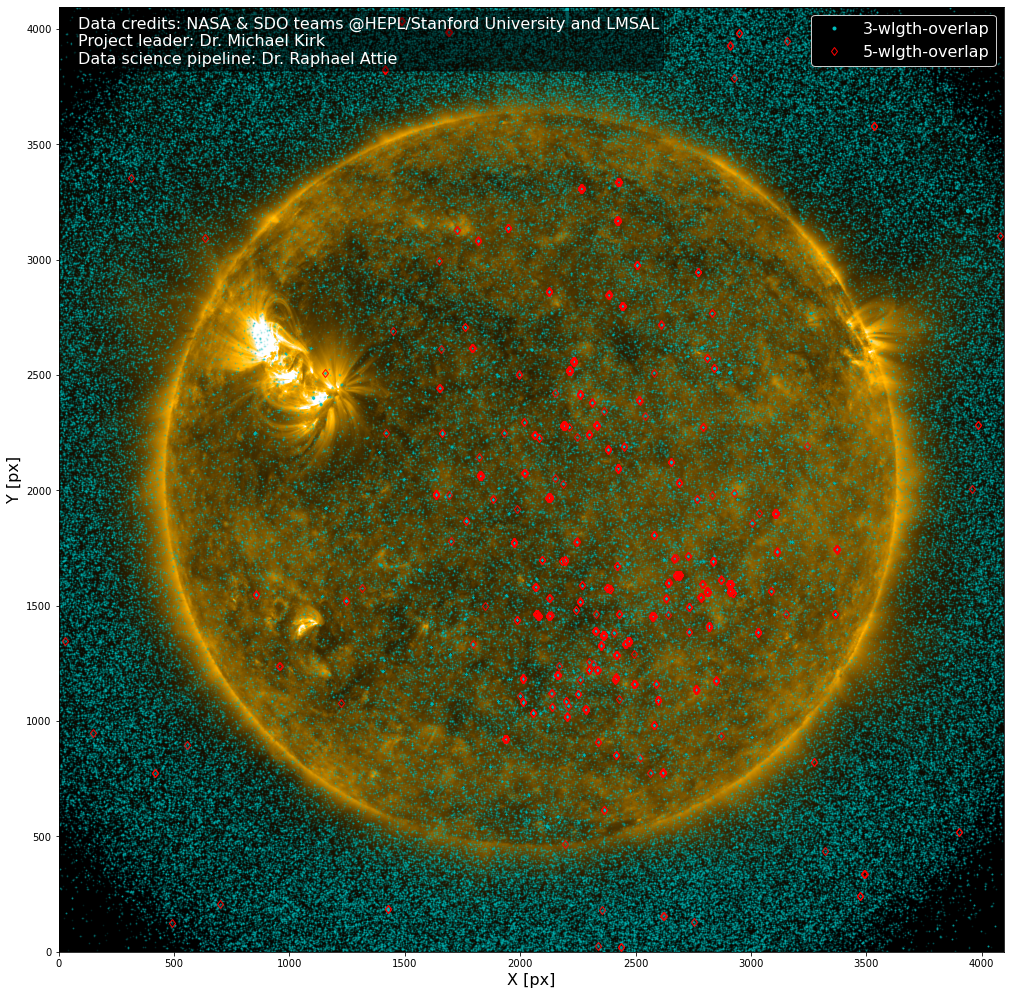

In [84]:
coords3 = df0.loc[seriesccount==3]['coords'].values
coords_x3 = coords3 % 4096
coords_y3 = coords3 // 4096

coords5 = df0.loc[seriesccount==5]['coords'].values
coords_x5 = coords5 % 4096
coords_y5 = coords5 // 4096


fig, ax = plt.subplots(figsize=(14,14))
plt.imshow(img, origin='lower', vmin=1, vmax=np.percentile(img, 99.9), 
           cmap=cmap, norm=colors.PowerNorm(gamma=0.6), zorder=0)

ax.set_facecolor('black')
plt.xlim(0, nx-1)
plt.ylim(0, ny-1)
ax.set_aspect(1)
plt.plot(coords_x3, coords_y3, 'c.', ms=2, label='3-wlgth-overlap', zorder=1, alpha=0.1)
plt.plot(coords_x5, coords_y5, 'rd', ms=6, markerfacecolor='none', label='5-wlgth-overlap', zorder=2)
#sdisk = plt.Circle((crpix, crpix), r_sun, color='orange', fill=False, linewidth=2, zorder=2)
#ax.add_artist(sdisk)
#plt.plot(coords_x2, coords_y2, 'b.', ms=6, label='Wave 2')
leg = plt.legend(fontsize=FS, loc='upper right', fancybox=True, framealpha=1, facecolor='black')
for text in leg.get_texts():
    text.set_color("white")
for handle in leg.legendHandles:
    handle._legmarker.set_markersize(6)
    handle._legmarker.set_alpha(1)
    
plt.xlabel('X [px]', fontsize=FS)
plt.ylabel('Y [px]', fontsize=FS)

# Text box
textstr = '\n'.join((
    'Data credits: NASA & SDO teams @HEPL/Stanford University and LMSAL',
    'Project lead: Dr. Michael Kirk',
    'Data science pipeline: Dr. Raphael Attie'))

props = dict(boxstyle='round', facecolor='black', alpha=0.5)
ax.text(0.02, 0.99, textstr, transform=ax.transAxes, fontsize=FS,
        verticalalignment='top', bbox=props, color='white')

plt.tight_layout()
plt.savefig('figures/overlap_3_5.png', dpi=120)

In [ ]:
len(coords3)

### Design method to extract unique coincidental events, lifting any ambiguity (conjugates, redundancies, ...)

In [ ]:
w1_idx = 4
w2_idx = 5
w3_idx = 6
w4_idx = 7

In [ ]:
groups = df0.index.unique()

In [ ]:
events12 = [get_2clusters(df0.loc[group_n].values, w1_idx, w2_idx, group_n) for group_n in groups]
df_events12 = pd.concat(events12)
df_events12 = df_events12.loc[(df_events12.wref2 == 1)]
print(len(events12))
df_events12.head()

In [ ]:
events14 = [get_2clusters(df0.loc[group_n].values, w1_idx, w4_idx, group_n) for group_n in groups]
df_events14 = pd.concat(events14)
df_events14 = df_events14.loc[(df_events14.wref2 == 3)]
df_events14.head()

In [ ]:
c12 = df_events12.groupby('GroupNumber').size().rename('coincidentals count for Wav 0 & Wav 1')
dfcount12 = pd.concat([gdates.loc[groups], c12], axis=1)
dfcount12.set_index('Time', inplace=True)
dfcount12.head()

In [ ]:
%matplotlib inline
ax = dfcount12.plot(figsize=(8,8), fontsize=14)
ax.legend(fontsize=16)

In [ ]:
# gn = groups[0]

# coords1 = df_events12.loc[df_events12['GroupNumber']==gn]['coords1'].values
# coords1 = df_events12['coords1'].values
# coords_x1 = coords1 % 4096
# coords_y1 = coords1 // 4096

# coords2 = df_events12.loc[df_events12['GroupNumber']==gn]['coords2'].values
# coords_x2 = coords2 % 4096
# coords_y2 = coords2 // 4096

In [ ]:
coords1 = df_events12['coords1'].values
coords_x1 = coords1 % 4096
coords_y1 = coords1 // 4096

sdisk = plt.Circle((crpix, crpix), r_sun, color='black', fill=False)
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim(0, nx-1)
plt.ylim(0, ny-1)
ax.set_aspect(1)
ax.add_artist(sdisk)
plt.plot(coords_x1, coords_y1, 'r.', ms=4, markerfacecolor='none', label='Wave 1')
#plt.plot(coords_x2, coords_y2, 'b.', ms=6, label='Wave 2')
plt.legend(fontsize=16, loc='upper right')